[SI] kg °C Pa J/kg  
psychrolib.GetHumRatioFromRelHum(TDryBulb, RelHum, Pressure)  
psychrolib.GetTWetBulbFromRelHum(TDryBulb, RelHum, Pressure)  
psychrolib.GetHumRatioFromEnthalpyAndTDryBulb(MoistAirEnthalpy, TDryBulb)  
psychrolib.GetMoistAirEnthalpy(TDryBulb, HumRatio)

XSteam(XSteam.UNIT_SYSTEM_MKS) # m/kg/sec/°C/bar/W

XSteam(XSteam.UNIT_SYSTEM_FLS) # ft/lb/sec/°F/psi/btu

XSteam(XSteam.UNIT_SYSTEM_BARE) # m/kg/sec/K/MPa/W

In [1]:
#!pip install psychrolib
#!pip install pyXSteam

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import psychrolib
psychrolib.SetUnitSystem(psychrolib.SI)
from pyXSteam.XSteam import XSteam
steamTable = XSteam(XSteam.UNIT_SYSTEM_MKS)
import scipy.integrate as integrate
import pandas as pd

In [4]:
R_const = 8.314 #J/K.mol

In [5]:
def quadrature(a,b):
    val_1 = a + (0.1 * b)
    val_2 = a + (0.4 * b)
    val_3 = a + (0.6 * b)
    val_4 = a + (0.9 * b)
    c = [val_1, val_2, val_3, val_4]
    return c

In [6]:
def CwbyR(x):
    return 8.712 + 1.25*(10**-3)*x - 0.18*(10**-6)*(x**2) #water Cp/R

In [7]:
def DH_Water(Ti,Tf):
    return integrate.quad(CwbyR,Ti,Tf)[0] * R_const * (1000 / 18) #J/kg

In [8]:
def NTUCal(a,b,c,d,e,f): #DBT,RelHum,P(Pa),T_HotWater,T_ColdWater,L/G
    HumRatio = psychrolib.GetHumRatioFromRelHum(a, b, c)
    Range = d - e
    T_Water4PList = quadrature(e,Range)
    
    H_Water = []
    for i in T_Water4PList:
        H_Water.append(steamTable.h_pt(c/100000,i) * 1000) #J/kg
        
    H_MoistAir_Inlet = psychrolib.GetMoistAirEnthalpy(a, HumRatio) #J/kg
    H_MoistAir_Outlet = H_MoistAir_Inlet + (f * DH_Water(e,d)) #J/kg
    H_MoistAir_Difference = H_MoistAir_Outlet - H_MoistAir_Inlet #J/kg
    H_Air4PList = quadrature(H_MoistAir_Inlet,H_MoistAir_Difference) #J/kg
    
    DH = []
    for i in range(4):
        DH.append(H_Water[i]-H_Air4PList[i]) #J/kg
    
    recipDH = []
    for i in DH:
        recipDH.append(1 / i)
        
    sumrecipDH = sum(recipDH)
    NTU = (sumrecipDH * DH_Water(e,d))/4
    return NTU

In [9]:
def CWList(start,stop,step):
  App_Dict={}
  for i in np.arange(App_Start, App_Stop+App_Step,App_Step):
    App_Dict["App_{}".format(i)]=i
  T_ColdWater_List = []
  for i in np.arange(App_Start, App_Stop+App_Step,App_Step):
    T_ColdWater_List.append(App_Dict["App_{}".format(i)] + T_WetBulb)
  return T_ColdWater_List

In [10]:
'''Insert conditions'''
T_DryBulb = 30
RelHum = 0.86
P_kPa = 101.325
T_HotWater = 40

App_Start = 1
App_Stop = 10
App_Step = 1

LG_Stop = 10
LG_Step = 0.01

In [11]:
P_Pa = P_kPa * 1000
T_WetBulb = psychrolib.GetTWetBulbFromRelHum(T_DryBulb,RelHum,P_Pa)

In [12]:
print(T_WetBulb)

27.998831810404912


In [13]:
LG_Ratio_List = []
for i in np.arange(LG_Step, LG_Stop+LG_Step, LG_Step):
  LG_Ratio_List.append(i)

In [14]:
df1 = pd.DataFrame(LG_Ratio_List)

In [15]:
df1.columns = ['L/G']

In [16]:
T_ColdWater_List = CWList(App_Start,App_Stop,App_Step)

In [17]:
T_ColdWater_List

[28.998831810404912,
 29.998831810404912,
 30.998831810404912,
 31.998831810404912,
 32.99883181040491,
 33.99883181040491,
 34.99883181040491,
 35.99883181040491,
 36.99883181040491,
 37.99883181040491]

In [18]:
for i in T_ColdWater_List:
  NTU_List = []

  for j in LG_Ratio_List:
    x = NTUCal(T_DryBulb,RelHum,P_Pa,T_HotWater,i,j)
    
    if x >= 0:
        NTU_List.append(x)
        continue
    
    else:
      df2 = pd.DataFrame(NTU_List)
      df2.columns = ['Cold Water Temp {:04.2f} °C'.format(i)]
      df1 = pd.concat([df1, df2],axis=1)
      break
        
    df2 = pd.DataFrame(NTU_List)
    df2.columns = ['Cold Water Temp {:04.2f} °C'.format(i)]
    df1 = pd.concat([df1, df2],axis=1)

In [19]:
df1.head(2)

,L/G,Cold Water Temp 29.00 °C,Cold Water Temp 30.00 °C,Cold Water Temp 31.00 °C,Cold Water Temp 32.00 °C,Cold Water Temp 33.00 °C,Cold Water Temp 34.00 °C,Cold Water Temp 35.00 °C,Cold Water Temp 36.00 °C,Cold Water Temp 37.00 °C
0,0.01,0.865280,0.745651,0.639211,0.543355,0.456174,0.376233,0.302423,0.233871,0.169880
1,0.02,0.868125,0.747839,0.640872,0.544590,0.457069,0.376858,0.302836,0.234124,0.170016


In [20]:
df1.tail(2)

,L/G,Cold Water Temp 29.00 °C,Cold Water Temp 30.00 °C,Cold Water Temp 31.00 °C,Cold Water Temp 32.00 °C,Cold Water Temp 33.00 °C,Cold Water Temp 34.00 °C,Cold Water Temp 35.00 °C,Cold Water Temp 36.00 °C,Cold Water Temp 37.00 °C
998,9.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
999,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df3 = pd.DataFrame()

In [22]:
df1 = pd.concat([df1, df3],axis=1)

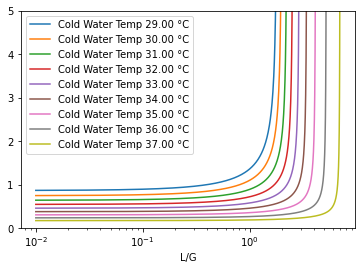

In [23]:
dfplot = df1.plot(x='L/G',logx=True,ylim=(0,5),legend=True)
fig = dfplot.get_figure()
fig.savefig("myplot.pdf",bbox_inches='tight')